In [23]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset

In [2]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Para encontrar el mejor modelo, probaremos utilizando 2 preprocesamientos distintos. Dado que boosting es un ensamble de árboles, los preprocesamientos serán los mismos que usamos para los árboles de decisión (particularmente los 2 primeros, ya que son los que obtuvieron mejores resultados en el notebook de árboles). Por cada uno de ellos, buscaremos la mejor combinación de hiperparámetros mediante Randomized Search, con el objetivo de maximizar la métrica AUC ROC.

Los hiperparámetros que buscaremos son:
- **min_samples_split:** es la mínima cantidad de muestras en cada nodo interno del árbol.
- **n_estimators:** es la cantidad de árboles que forman parte del ensamble. En Random Forest se utilizan árboles con alta varianza (por esa razón no se limita la profundidad de los árboles), y al juntar en un ensamble muchos de ellos se busca reducir esa varianza y que clasifiquen mejor. Como el entrenamiento puede tardar mucho si se usan muchos estimadores, usaremos entre 5 y 20 estimadores.

En primer lugar probamos con el dataset completo, codificando las variables categóricas con One Hot Encoding:

In [3]:
X_train1 = preprocessing_arboles_1(X_train)
params = {
    'min_samples_split': np.arange(2, 10),
    'n_estimators': np.arange(5, 20),
}

clf = RandomForestClassifier(random_state=0)

rgscv = RandomizedSearchCV(
    clf, params, n_iter = 60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8733066185623768
Best params {'n_estimators': 18, 'min_samples_split': 8}


El segundo preprocesamiento elimina los features categóricos:

In [4]:
X_train2 = preprocessing_arboles_2(X_train)
params = {
    'min_samples_split': np.arange(2, 10),
    'n_estimators': np.arange(5, 20),
}

clf = RandomForestClassifier(random_state=0)


rgscv = RandomizedSearchCV(
    clf, params,  n_iter = 60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: 0.8699407934259418
Best params {'n_estimators': 19, 'min_samples_split': 9}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_arboles_1, con 'n_estimators': 18, 'min_samples_split': 8.
Entrenamos el modelo y evaluamos utilizando el set de evaluacion.

In [17]:
X_eval = preprocessing_arboles_1(X_eval)

clf = RandomForestClassifier(n_estimators= 18, min_samples_split= 8)
clf.fit(X_train1, y_train)

y_pred = clf.predict(X_eval)
y_pred_proba = clf.predict_proba(X_eval)[:,1]

In [18]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8804423318857304
Accuracy: 0.8550014989507345
Precision: 0.7541974479516454
Recall: 0.5086050724637681
F1 Score: 0.6075196104949958


De las métricas podemos destacar que se obtuvo un accuracy de 0.86, mayor que el accuracy del baseline obtenido en el TP1 (0.83). Dado que el accuracy no es una buena métrica para evaluar un modelo cuando se usa un dataset desbalanceado como este, la métrica que usamos para comparar los modelos es AUC, la cual tiene un valor de 0.88.

También vemos que el recall obtenido (0.51) es mucho menor que el precision (0.75). Esto significa que, de todas las instancias que son realmente positivas (es decir, llueven hamburguesas al día siguiente), el modelo solo detecta correctamente el 51% de ellas. Por otro lado, de las que el modelo predice como positivas, el 75% eran realmente positivas.

Si comparamos estos resultados con los del otro ensamble (Boosting), vemos que el recall obtenido fue menor, pero el precision fue mayor. Esto significa que nuestro modelo de Random Forest puede ser más útil que Boosting si se quisiera obtener una menor cantidad de falsos positivos.

Por último, el F1 Score permite tener una única métrica para evaluar el modelo, teniendo en cuenta el recall y el precision:

    F1 = 2 x (precision x recall) / (precision + recall) = 0.61

Para analizar con más detalle estas métricas, graficaremos la matriz de confusión y la curva ROC.

## Matriz de confusion

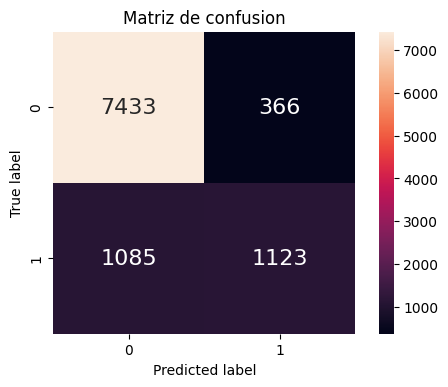

In [24]:
names = sorted(set(y_eval))
cm = confusion_matrix(y_eval, y_pred)
df_cm = pd.DataFrame(cm, names, names)

plt.figure(dpi=100)
plt.title("Matriz de confusion")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

En la matriz de confusión podemos observar exactamente cuántas instancias fueron predichas como True Positive, True Negative, False Positive y False Negative. A partir de estos datos se pueden calcular las métricas, verificando los resultados obtenidos anteriormente:
- Recall = TP/(TP+FN) = 1123/(1123+1085) = 0.51
- Precision = TP/(TP+FP) = 1123/(1123+366) = 0.75
- Accuracy = (TP+TN)/total = 8556/10007 = 0.86

## Curva ROC

La curva ROC se obtiene al graficar el True Positive Rate (Recall) vs el False Positive Rate, variando el umbral de detección entre 0 y 100%. Si las predicciones hechas fueran completamente aleatorias, la curva sería una recta, con un área bajo la curva de 0.5. El área bajo la curva es la métrica que se obtiene de la curva, y por eso se busca obtener valores mayores que 0.5. En este caso se obtuvo un AUC = 0.88, el cual es un buen valor comparado con otros modelos utilizados en este TP.

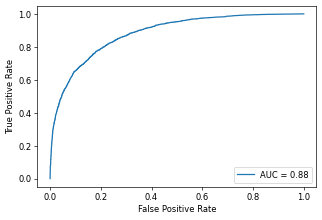

In [21]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales
Finalmente, utilizaremos el modelo para predecir la lluvia de hamburguesas a partir de datos que no fueron usados en el entrenamiento. Guardaremos las predicciones en un archivo csv.

In [25]:
X_train1 = preprocessing_arboles_1(X_train)

clf = RandomForestClassifier(n_estimators= 19, min_samples_split= 4)
clf.fit(X_train1, y_train)

df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_arboles_1(df_pred_preprocess)

y_pred_final = clf.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

df_pred_final['llovieron_hamburguesas_al_dia_siguiente'].value_counts()

no    24690
si     4402
Name: llovieron_hamburguesas_al_dia_siguiente, dtype: int64

In [26]:
df_pred_final.to_csv('predicciones/random_forest.csv', index=False)